<a href="https://colab.research.google.com/github/Aisuluu1405/Test_Lesson_6_AI/blob/master/Lesson6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AI марафон, лекция 6
Практика: Нейронные сети
alt text

In [0]:
# PyTorch

import torch
import torchvision
# import torchtext

import matplotlib.pyplot as plt # для визуализации
import numpy as np # пара базовых функций

# мы хотим использовать видеокарту для вычислений
device = torch.device('cuda') # cuda = видеокарты / cpu = процессор
# для того, чтобы включить видеокарту Runtime -> Change runtime type -> GPU


Что важно знать о библиотеках
У большинства библиотек в Python есть документация, где детально описаны функции и классы. Например, документацию NumPy вы можете найти здесь: https://numpy.org/doc/ , а документацию PyTorch здесь: https://pytorch.org/docs/stable/index.html.

Эта документация очень полезна не только для понимания функций, но и для проверки параметров, которые есть у различных функций в библиотеках.

Где искать ответы на практические вопросы
https://stackoverflow.com/ - ресурс с ответами на вопросы о программировании, включая machine learning.

На Kaggle вы тоже можете найти туториалы по использованию различных библиотек.



1. Загружаем и трансформируем данные

---


[

In [0]:
#torchvision библиотека с датасетами
transform = torchvision.transforms.ToTensor() # трансформируем данные из изображения в вектор (или, как они называются в PyTorch, tensor), конвертирует в матрицы и пиксели

# Загружаем датасет CIFAR10
train_cifar = torchvision.datasets.CIFAR10('/', train=True, transform=transform, target_transform=None, download=True)   #target-цель не трансформируем, download=True, действительно хотим скачать датасет
test_cifar = torchvision.datasets.CIFAR10('/', train=False, transform=transform, target_transform=None, download=True)


Extracting /cifar-10-python.tar.gz to /
Files already downloaded and verified


In [0]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


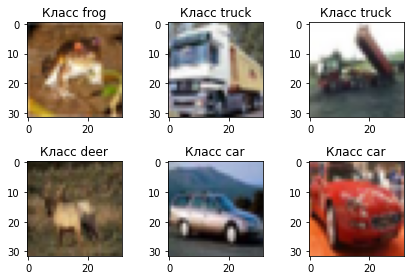

Размер каждого изображения: (32, 32, 3)


In [0]:
#визуализация нескольких примеров

fig = plt.figure()
i = 0
for image, label in train_cifar:
  image = torchvision.utils.make_grid(image)   #трансформирует матрицу и векторы обратно в изображения                
  image = image.numpy()
  image = np.transpose(image, (1, 2, 0))
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(image)
  plt.title(f'Класс {classes[label]}')           #цель
  
  i += 1
  if i == 6:                #проходим по первым 6 изображениям
    plt.show()  
    print(f'Размер каждого изображения: {image.shape}')
    break

In [0]:
# назначаем размер наших batch для тренировки и тестирования модели
batch_size_train = 50              # берет по 50 и тренирует
batch_size_test = 500

# при итерации через train_loader мы получаем batches размером в 50  в одном куске 50 изображений
train_loader = torch.utils.data.DataLoader(train_cifar,
  batch_size=batch_size_train, shuffle=True) # параметр шафл перемешивает изображения при создании batches, используется в тренировочных данных

# при итерации через test_loader мы получаем batches размером в 500
test_loader = torch.utils.data.DataLoader(test_cifar,              # когда будем итерировать будут возращаться batches
  batch_size=batch_size_test, shuffle=False)                      #shuffle=False - не перемешивать


In [0]:
print(f'Изображений в тренировочных данных: {len(train_loader) * batch_size_train}')
print(f'Изображений в тестируемых данных: {len(test_loader) * batch_size_test}')

Изображений в тренировочных данных: 50000
Изображений в тестируемых данных: 10000


2. Создаем и тренируем логистическую модель через PyTorch

In [0]:
# импортируем отдельные функции из библиотеки PyTorch, для краткости
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Создаем нашу модель в PyTorch
class LogisticRegression(nn.Module): # говорим питону что наш class LogisticRegression это пример модуля nn.Module, дает доступ к функциям pytorch

  # инициализируем нашу модель
  def __init__(self, input_dim, output_dim):
    super(LogisticRegression, self).__init__()
    # nn.Linear создает связи (с параметрами, первый-сколько нейронов во входном слое, второй-сколько нейронов на последнем  слое) между двумя слоями сети
    self.regression = nn.Linear(in_features=input_dim,              #используем функцию 
                                out_features=output_dim)
  # эта функция совершает один прогноз для наших входных данных X
  def forward(self, x): # x наши входные данные
    # не берет Y цель как один из параметров

    predictions = self.regression(x)
    return predictions # возвращаем наши прогнозы

In [0]:

logreg = LogisticRegression(input_dim=32 * 32 * 3, # входной слой нашей регрессии 32*32*3 переменных (или нейронов) 
                            output_dim=10 # слой на выходе размером 10 (10 классов объектов в датасете)
                            ).to(device) # отправляет нашу модель в видеокарту

In [0]:
print(f'Число параметров в логистической регресии: {sum(p.numel() for p in logreg.parameters())}')
print(32*32*3*10+10)      # +10 параметров B zero(B0)


Число параметров в логистической регресии: 30730
30730


Вопрос: Какие 4 компонента нужны были для тренировки модели для прогнозирования?

1.Данные (входные и цели) train_loader, test_loader
2.Модель logreg
3.Функция потерь или loss function
4.Метод оптимизации (градиентное обучение)

In [0]:
# создаем функцию потерь
# при классификации, функция потерь CrossEntropyLoss
# бинарной классификации, функция потерь BCELoss
loss_function = nn.CrossEntropyLoss().to(device) # отправили в видеокарту

# создаем метод оптимизации
# SGD = stochastic gradient descent, метода градиентного обучения
# связываем между собой метод оптимизации и модель
# lr = learning rate, который определяет величину шага при градиентном обучении
# learning rate это гиперпараметер, в большинстве learning rate относительно маленький, не хотим быстро двигаться, чтобы хаотичности не было(в начале лучше больший, в конце маленький лучше)
optimizer = optim.SGD(logreg.parameters(), lr=0.001)    #обозначая параметры, связываем модель и метод оптимизации

In [0]:
# создаем функцию которая тренирует нашу модель в течение одной эпохи
# эпоха - прохождение через все batches в наших тренируемых данных один раз
# тренировка в течение 5 эпох -- наша модель увидит каждое изображение в данных как минимум 5 раз

def train_epoch(model, loader, epoch, flatten=True):  #берет как параметры саму модель, какие данные_loader, номер эпохи, flatten-техническая деталь

  # в них хранятся значения нашей потери и точности
  epoch_loss = 0
  epoch_accuracy = 0

  # в этом for loop мы проходим через все 1000 batches в наших трен. данных
  for i, batch in enumerate(loader):
    
    images, labels = batch # images = X, labels = Y разбили на два компонента
    if flatten:
      images = images.reshape((batch_size_train, -1)) # сжимает нашу матрицу, меняет порядок колонок в матрице

    # optimizer = метод оптимизации
    # zero_grad() после каждого batch стирает буфер информации с прошлого batch
    optimizer.zero_grad()           

    # model.forward() совершает forward pass  не делаем обучения, а только пропускает данные и выдает цель  
    # images = X, output = Y_hat       
    output = model.forward(images.to(device)) # отправляем данные в видеокарту, вектор, вероятность, что изображена кошка
    
    # посчитать потерю между нашим прогнозом output и настоящей целью labels
    loss = loss_function(output, labels.to(device)) # отправляем данные в видеокарту

    if i == 0 and epoch == 0:
      print(f'Размер изображений в batch: {images.shape}')
      print(f'Размер целей в batch: {labels.shape}')
      print(f'Размер прогнозов в batch: {output.shape}')
    elif i == len(train_loader) - 1:
      print(f'Эпоха {epoch+1}. Обработал {i * batch_size_train} изображений.')
      print(f'Потеря: {epoch_loss / (i + 1)}, точность: {epoch_accuracy / (i + 1)}')
    
    # backward pass = обновление параметров нашей модели, в завимости от ошибок, которые она допустили
    # наши ошибки хранятся в значении функции потерь 
    loss.backward() # высчитывает градиент для обновления параметров раьотаем в тандеме с optimizer.step()
    optimizer.step() # обновляет сами параметры внутри модели, используя градиенты из прошлой строки

    epoch_loss += loss.item() # добавляем свою потерю

    predictions = output.argmax(dim=-1) # команда argmax находит позицию максимального значению внутри нашего вектора, найи позицию, а не само изображение
    # в python индекс -1 обозначает последний индекс

    correct_predictions = int(sum(predictions == labels.to(device)))           #сравни два значения, вектор 50, а если были правильные предсказания 40, то 40/50(40 делим на 50)
    accuracy = correct_predictions / batch_size_train
    epoch_accuracy += accuracy

  return epoch_loss, epoch_accuracy


Любую модель в PyTorch можно натренировать по следующим шагам.

Взять один batch данных (X, Y)

Очистить буфер метода оптимизации optimizer (в буфере находятся градиенты с прошлого batch)

Совершить один forward pass (создание прогнозов на основе входных данных X)

Высчитываем функцию потерь между нашими прогнозами (Y_hat) и настоящими целями (Y)

Совершаем один backward pass (высчитываем градиенты для обновления параметров)

Используем optimizer.step() для обновления самих параметров внутри модели

Высчитываем точность наших прогнозов на этом batch

Шаги 1-7 повторяем для всех batches в тренируемых данных

Шаг 8 повторяем N раз, где N = максимальное количество эпох (гиперпараметер)

In [0]:
losses = []
accuracies = []
num_epochs = 5

for epoch in range(num_epochs):                  #тренируем 5 раз, так как указали 5 эпох
  epoch_loss, epoch_accuracy = train_epoch(logreg, train_loader, epoch)        #
  losses.append(epoch_loss / len(train_loader))
  accuracies.append(epoch_accuracy / len(train_loader))

In [0]:
plt.plot(losses)
plt.legend(['train'])
plt.title('losses')
plt.show()

plt.plot(accuracies)
plt.legend(['train'])
plt.title('accuracy')
plt.show()


In [0]:
# тестирует нашу модель на всех тестируемых данных
# в этой функции нет никакого обучения
# много forward passes
# записываем loss и accuracy
def test_epoch(model, loader, flatten=True):
  epoch_loss = 0
  epoch_accuracy = 0
  for i, batch in enumerate(loader):
    images, labels = batch
    if flatten:
      images = images.reshape((batch_size_test, -1))
    output = model.forward(images.to(device))
    loss = loss_function(output, labels.to(device))

    epoch_loss += loss.item()

    predictions = output.argmax(dim=-1)
    correct_predictions = int(sum(predictions == labels.to(device)))
    accuracy = correct_predictions / batch_size_test
    epoch_accuracy += accuracy
  return epoch_loss, epoch_accuracy

In [0]:
logreg = LogisticRegression(input_dim=32 * 32 * 3, output_dim=10).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(logreg.parameters(), lr=0.001)

test_losses = []
test_accuracies = []

train_losses = []
train_accuracies = []
num_epochs = 20

for epoch in range(num_epochs):
  train_loss, train_accuracy = train_epoch(logreg, train_loader, epoch)
  train_losses.append(train_loss / len(train_loader))
  train_accuracies.append(train_accuracy / len(train_loader))
  with logreg.eval() and torch.no_grad():
    test_loss, test_accuracy = test_epoch(logreg, test_loader)
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_accuracy / len(test_loader))


In [0]:
# функция которая визуализирует потери и точность по истечении эпох
# ось X = какая эпоха
# ось Y = значение потери / точности на данной эпохе

def plot_training(train_losses, test_losses, train_accuracies, test_accuracies):
  plt.plot(train_losses)
  plt.plot(test_losses)
  plt.legend(['train', 'test'])
  plt.title('losses')
  plt.show()

  plt.plot(train_accuracies)
  plt.plot(test_accuracies)
  plt.legend(['train', 'test'])
  plt.title('accuracy')
  plt.show()

plot_training(train_losses, test_losses, train_accuracies, test_accuracies)

3. Создаем и тренируем глубокую нейросеть

In [0]:
# создаем нейронную сеть
class DeepNeuralNetwork(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dims):
    # input_dim = размер первого слоя (32 * 32 * 3)
    # output_dim = размер последного слоя (10)
    # hidden_dims = лист с размерами промежуточных слоев
    # 300, 150, 50 = три слоя
    super(DeepNeuralNetwork, self).__init__()

    # первый слой - это входные данные, размер 3072 = 32 * 32 * 3
    # второй слой - это промежуточный слой
    # размер второго слоя - это гиперпараметер
    self.input_to_hidden_layer = nn.Linear(input_dim, hidden_dims[0])

    # добавляем нелинейность (нет параметров)
    self.first_nonlinearity = nn.ReLU()

    # создаем пустой список для дальнейших промежуточных слоев
    self.hidden_layers = nn.ModuleList()

    # добавляем промежуточные слои к нашей модели
    for i in range(len(hidden_dims) - 1):
      # каждый nn.Linear и есть слой внутри нейросети
      self.hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
      # добавляем нелинейность (нет параметров)
      self.hidden_layers.append(nn.ReLU())  
    
    # self.hidden_layers.append(nn.Linear(hidden_dims[0], hidden_dims[1]))
    # self.hidden_layers.append(nn.Linear(hidden_dims[1], hidden_dims[2]))

    # добавляем связи между последним промежуточным слоем и последним слоем нейросети (классы)
    self.hidden_to_output_layer = nn.Linear(hidden_dims[-1], output_dim)

  # функция которая создает прогноз на основе входных данных
  def forward(self, x):

    after_first_layer = self.input_to_hidden_layer(x)

    hidden_input = self.first_nonlinearity(after_first_layer)

    for hidden_layer in self.hidden_layers:
      hidden_input = hidden_layer(hidden_input)

    predictions = self.hidden_to_output_layer(hidden_input)
    return predictions

In [0]:
deepnn = DeepNeuralNetwork(input_dim=32 * 32 * 3, 
                           output_dim=10, 
                           hidden_dims=[300, 150, 50]).to(device) # размер и число промежуточных слоев это гиперпараметер

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(deepnn.parameters(), lr=0.001) # параметер optimizer это deepnn, а не logreg
print(sum(p.numel() for p in deepnn.parameters()))


test_losses = []
test_accuracies = []

train_losses = []
train_accuracies = []
num_epochs = 20

for epoch in range(num_epochs):
  train_loss, train_accuracy = train_epoch(deepnn, train_loader, epoch)
  train_losses.append(train_loss / len(train_loader))
  train_accuracies.append(train_accuracy / len(train_loader))
  with deepnn.eval() and torch.no_grad():
    test_loss, test_accuracy = test_epoch(deepnn, test_loader)
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_accuracy / len(test_loader))

In [0]:
plot_training(train_losses, test_losses, train_accuracies, test_accuracies)

In [0]:
300 * 150

3. Создаем и тренируем конволюционную нейросеть

In [0]:
class ConvolutionalNeuralNetwork(nn.Module):
  def __init__(self):
    super(ConvolutionalNeuralNetwork, self).__init__()
    # вместо промежуточных слоев nn.Linear используем конволюционные nn.Conv2d
    self.convolution_1 = nn.Conv2d(in_channels=3, # 1 или 3, изображение цветное или монохромное
                                   out_channels=6, # увеличиваем число каналов для компенсации меньшего размера изображения
                                   kernel_size=5, # размер нашего фильтра 
                                   stride=1, # размере шага при движении фильтра
                                   padding=0 # что делать на краях изображения
                                   )
    self.non_linearity = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # операция для уменьшения размера изображения, у MaxPool нет параметров
    self.convolution_2 = nn.Conv2d(in_channels=6, 
                                   out_channels=16, 
                                   kernel_size=5)
    self.fc_1 = nn.Linear(16 * 5 * 5, 120) # 16 * 5 * 5  < 32 * 32 * 3 более компактная репрезентация
    self.fc_2 = nn.Linear(120, 84) # предпоследний промежуточный слой размером в 120
    self.fc_3 = nn.Linear(84, 10) # последний промежуточный слой размером в 84
    # последний слой размером в 10

  def forward(self, x):
    # print(x.shape)
    after_convolution_1 = self.non_linearity(self.convolution_1(x))
    # print(after_convolution_1.shape)
    after_pool_1 = self.pool(after_convolution_1)
    # print(after_pool_1.shape)
    after_convolution_2 = self.non_linearity(self.convolution_2(after_pool_1))
    # print(after_convolution_2.shape)
    after_pool_2 = self.pool(after_convolution_2)
    # print(after_pool_2.shape)

    flat_input = after_pool_2.view(-1, 16 * 5 * 5)
    after_fc_1 = self.non_linearity(self.fc_1(flat_input))
    after_fc_2 = self.non_linearity(self.fc_2(after_fc_1))
    predictions = self.fc_3(after_fc_2)
    
    return predictions

In [0]:
32 * 32 * 3

In [0]:
cnn = ConvolutionalNeuralNetwork().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.005)
print(sum(p.numel() for p in cnn.parameters()))


test_losses = []
test_accuracies = []

train_losses = []
train_accuracies = []
num_epochs = 20

for epoch in range(num_epochs):
  train_loss, train_accuracy = train_epoch(cnn, train_loader, epoch, flatten=False)
  train_losses.append(train_loss / len(train_loader))
  train_accuracies.append(train_accuracy / len(train_loader))
  with deepnn.eval() and torch.no_grad():
    test_loss, test_accuracy = test_epoch(cnn, test_loader, flatten=False)
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_accuracy / len(test_loader))

In [0]:
plot_training(train_losses, test_losses, train_accuracies, test_accuracies)